In [1]:
######################################################################################################
## STEP 1: IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS
######################################################################################################
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components


In [2]:
######################################################################################################
## STEP 2: USANDO HAAR CASCADE PARA DETECTAR CARACTERÍSTICAS FACIAIS
######################################################################################################

# Função que recebe uma imagem colorida como entrada e retorna a mesma imagem convertida para escala de cinza
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Converter a imagem de um espaço de cores RGB para escala de cinza
    return gray

# Função que usará um modelo para detectar o rosto de uma pessoa
def detect_faces(image, face_classifier):
    faces = face_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return faces

# Função que usará um modelo para detectar os olhos de uma pessoa
def detect_eyes(image, eyes_classifier):
    eyes = eyes_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return eyes

# Função que usará um modelo para detectar o nariz de uma pessoa
def detect_noses(image, nose_classifier):
    noses = nose_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return noses

# Função que usará um modelo para detectar a boca de uma pessoa
def detect_mouths(image, mouth_classifier):
    mouths = mouth_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return mouths

# Função que irá nos retornar os contornos de uma imagem
def apply_canny(image):
    edges = cv2.Canny(image, 150, 200)
    return edges

# Função que plotará imagens
def plots(figura, title=''):
    plt.figure(figsize=(20,10))
    plt.imshow(figura, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Função que aleatoriza 
def retirando_pixels(mEdges, thresh):
    lCoord = [] # Lista para armazenar as coordenddas dos pixels de interesse

    for i in range(mEdges.shape[0]):
        for j in range(mEdges.shape[1]):
            if mEdges[i][j] == 255: # Verificando se o ponto encontrado corresponde ao pixel 255
                lCoord.append((i,j)) # Adicionando a coordenada desse pixel encontrado no lCoord
    mainCoord = lCoord.copy() # Copiando a lista de coordenadas dos pontos (coordenadas dos pixels de interesse)
    random.shuffle(lCoord) # Aleatorizando a ordem das coordenadas dos pontos

    times = thresh # Definando um limiar para zerarmos os pixels

    #for i,t in zip(lCoord, range(times)): # Zipamos a lista de coordenadas com o limiar para definirmos um 'critério de parada' no laço
    #        mEdges[i[0]][i[1]] = 0 # Zerando os pixels 255

    return mEdges, mainCoord

# Função que fará o processamento de imagem e nos retornará os contornos das características
def process_image(image_path, face_classifier, eyes_classifier, nose_classifier, mouth_classifier):
    image = cv2.imread(image_path) # Lendo a imagem
    processed_image = preprocess_image(image) # Pré-processando a imagem (convertendo para escala de cinza)
    faces = detect_faces(processed_image, face_classifier) # Detectando o rosto na imagem

    for (x, y, w, h) in faces:
        face_roi = processed_image[y:y+h, x:x+w] # Recortando a região de interesse (Roi) do rosto
        noses = detect_noses(face_roi, nose_classifier) # Detectando o nariz na região de interesse do rosto

        for (nx, ny, nw, nh) in noses:
            nose_roi = face_roi[ny:ny+nh, nx:nx+nw] # Recortando a região de interesse (Roi) do nariz
            plots(nose_roi, title="ROI Nariz") # Plotando a região de interesse do nariz
            nariz_contornos = apply_canny(nose_roi) # Aplicando o detector de bordas de Canny na região de interesse do nariz
            plots(nariz_contornos, title="Contornos com Canny")
            newNoseEdges, mainCoord_nose = retirando_pixels(nariz_contornos, 100)
    
    # for (x, y, w, h) in faces:
    #     face_roi = processed_image[y:y+h, x:x+w]
    #     mouth = detect_mouths(face_roi, mouth_classifier)

    #     for (mx, my, mw, mh) in mouth:
    #         mouth_roi = face_roi[my:my+mh, mx:mx+mw]
    #         plots(mouth_roi, title="ROI Boca")
    #         mouth_contornos = apply_canny(mouth_roi)
    #         plots(mouth_contornos, title="Contornos com Canny")
    #         newMouthEdges, mainCoord_mouth = retirando_pixels(mouth_contornos, 100)

    return nariz_contornos, mainCoord_nose


In [3]:
######################################################################################################
## STEP 3: CRIANDO MATRIZ DE ADJACENCIAS COM AS LIGAÇÕES ENTRE OS PONTOS PARA MONTAR GRAFOS
######################################################################################################

# Função para processar a matriz e retornar as ligações entre os pontos
def processar_matriz(matriz, limViz1, limViz2):
    def coord_pts(matriz):
        dAuxiliar = {}  # Um dicionário auxiliar para armazenar as coordenadas dos pontos
        pto = 0  # Um contador para contabilizarmos os pontos
        for i in range(matriz.shape[0]):
            for j in range(matriz.shape[1]):
                if matriz[i][j] == 255:  # Verificando se o ponto encontrado corresponde ao pixel 255
                    dAuxiliar[(i, j)] = pto  # Adicionando esse pixel encontrado no dAuxiliar
                    pto += 1
        return dAuxiliar

    def linha_coluna(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        return x1 == x2 or y1 == y2

    def diagonal(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        return abs(x1 - x2) == abs(y1 - y2)

    def distancia_absoluta(ponto1, ponto2):
        distancia_x = abs(ponto1[0] - ponto2[0])
        distancia_y = abs(ponto1[1] - ponto2[1])
        return distancia_x + distancia_y

    def vizinhanca(ponto1, ponto2, limite):
        distancia = distancia_absoluta(ponto1, ponto2)
        return distancia <= limite

    def verificar_vizinhanca(pontos, limViz1, limViz2):
        ligacoes = {}  # Dicionário para armazenar as ligações entre os pontos
        for ponto1, id1 in pontos.items():
            ligacoes[id1] = []  # Inicializa a lista de ligações para o ponto atual
            for ponto2, id2 in pontos.items():
                if ponto1 != ponto2:  # Evitar calcular a distância do ponto com ele mesmo
                    if linha_coluna(ponto1, ponto2):  # Verificando se os pontos estão na mesma linha/coluna
                        if vizinhanca(ponto1, ponto2, limViz1):  # Verificando se as distâncias estão dentro do limite imposto
                            ligacoes[id1].append(id2)  # Adicionar a ligação entre os pontos ao dicionário de ligações

        for ponto1, id1 in pontos.items():
            for ponto2, id2 in pontos.items():
                if ponto1 != ponto2:  # Evitar calcular a distância do ponto com ele mesmo
                    if diagonal(ponto1, ponto2):  # Evitar calcular a distância do ponto com ele mesmo
                        if vizinhanca(ponto1, ponto2, limViz2):  # Verificando se as distâncias estão dentro do limite imposto
                            ligacoes[id1].append(id2)  # Adicionar a ligação entre os pontos ao dicionário de ligações
        return ligacoes

    pontos = coord_pts(matriz)
    resultado = verificar_vizinhanca(pontos, limViz1, limViz2)
    return resultado

# Função para criar a matriz de adjacências
def matriz_adjacencias(graph_dict):
    n = max(graph_dict.keys()) + 1 # Encontra o maior número de nó no grafo e adiciona 1 a ele para ajustar a indexação que começa em 0 no python
    M = np.zeros((n,n)) # Uma matriz de adjacência quadrada n = qtde pixels 255
    
    for node, neighbors in graph_dict.items(): #Itera sobre o dicionário onde cada chave representa um nó e o valor é uma lista de vizinhos desse nó.
        for neighbor in neighbors: # Itera sobre a lista de vizinhos do nó atual.
            M[node][neighbor] = 1 # Define a entrada correspondente na matriz de adjacência como 1 para indicar uma aresta entre o nó node e o vizinho neighbor.
    
    return M


In [4]:
######################################################################################################
## STEP 4: ENCONTRANDO OS PRINCIPAIS COMPONENTES CONECTADOS E OS FILTRANDO
######################################################################################################

# Função para encontrar as principais componentes conectados
def main_connected_components(all_mAdjNose):

    ## Encontrar os componentes conectados na matriz de adjacências
    comp_conectadas, labels = connected_components(all_mAdjNose[0]) # Encontrar os componentes conectados na matriz de adjacências  (comp_conectadas = número de componentes conectados, labels = rótulos dos componentes conectados)

    ## Criando um dicionário para armazenar os rótulos das componentes conectadas e seus respectivos índices
    connectedComponentLabels = {} 

    for i in range(len(labels)): # Iterar sobre os labels e seus respectivos índices
        if labels[i] not in connectedComponentLabels: # Verificar se o label atual já está no dicionário
            connectedComponentLabels[labels[i]] = [i] # Se não estiver, adiciona o índice atual em uma lista
        else:
            connectedComponentLabels[labels[i]].append(i) # Se já estiver, adiciona o índice atual à lista de índices

    print('Dicionário de labels:', connectedComponentLabels)

    ## Dicionário auxiliar para armazenar o número de nó em cada conexo
    componentNodeCount = {}

    for i in connectedComponentLabels.keys(): # Iterar sobre as chaves do dicionário de labels
        componentNodeCount[i] = len(connectedComponentLabels[i]) # Adicionar o número de conectividades em cada conexo ao dicionário auxiliar
    print('Dicionário com a quantidade de nós:',componentNodeCount) 

    ## Encontrar o maior e o menor número de nós em um conexo
    maxNodeComponent = max(componentNodeCount, key=componentNodeCount.get)
    print('Maior nº de nós em um conexo:', componentNodeCount[maxNodeComponent])
    minNodeComponent = min(componentNodeCount, key=componentNodeCount.get) 
    print('Menor nº de nós em um conexo:', componentNodeCount[minNodeComponent])

    # Lista para armazenar as chaves (componentes conexas) que serão deletadas
    componentsToRemove = []

    for key in componentNodeCount.keys(): # Iterar sobre as chaves do dicionário que armazena o número de nós em cada componente
        if componentNodeCount[key] < round(0.2 * componentNodeCount[maxNodeComponent]): # Verificar se o número de nós é menor que 20% do maior número de nós
            componentsToRemove.append(key) # Adicionar a componente à lista de componentes que serão deletadas

    ## Filtrar as componentes conectadas mantendo apenas as principais
    for key in componentsToRemove: # Iterar sobre a lista de componentes que serão deletadas
        del componentNodeCount[key] # Deletar a componente do dicionário componentNodeCount

    listMainComponents = componentNodeCount.keys() # Lista para armazenar as componentes que serão mantidas
    print('Lista das chaves que serão filtradas:', listMainComponents)

    ## Dicionário para armazenar os principais componentes conectados e seus respectivos nós
    dicMainComponents = {}

    for key in listMainComponents: # Iterar sobre as chaves (componentes) que serão mantidas
        dicMainComponents[key] = connectedComponentLabels[key] # Adicionar os nós dos componentes que serão mantidos ao dicionário dos principais componentes conectados

    print('Dicionário com os labels filtrados:', dicMainComponents)
    return dicMainComponents, connectedComponentLabels


In [5]:
######################################################################################################
## STEP 5: DESTACANDO OS PONTOS DAS COMPONENTES CONECTADAS
######################################################################################################

def highlight_components(mainCoord, dicMainComponents):
    '''
    Função para plotar os pontos das componentes conectadas

    - mainCoord: lista de coordenadas dos pontos de interesse
    - dicMainComponents: dicionário com os índices dos pontos filtrados por componente conectada
    '''
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black']
    plt.figure(figsize=(8, 6))
    
    for color,label in enumerate(dicMainComponents.keys()): # Iterar sobre as chaves do dicionário que contém os principais componentes conectados
        for idx in dicMainComponents[label]: # Iterar sobre os nós dos componentes conectados
            i, j = mainCoord[idx] # Obter as coordenadas dos pontos
            # print(i, j, idx)
            plt.scatter(j, i, color=colors[color%len(colors)])  # Plotar os pontos filtrados
    
    plt.title("Pontos das Componentes Conectadas")
    plt.xlabel("Coluna")
    plt.ylabel("Linha")
    plt.gca().invert_yaxis()  # Inverter o eixo y para corresponder à orientação das imagens OpenCV
    plt.grid(True)
    plt.show()

def main():
    directory = './image'
    face_classifier = cv2.CascadeClassifier("./models/haarcascade_frontalface_default.xml")
    eyes_classifier = cv2.CascadeClassifier("./models/haarcascade_eye.xml")
    nose_classifier = cv2.CascadeClassifier("./models/haarcascade_mcs_nose.xml")
    mouth_classifier = cv2.CascadeClassifier("./models/haarcascade_mcs_mouth.xml")
    
    all_mAdjNose = []

    for filename in os.listdir(directory):
        if filename.endswith("pedro.jpg") or filename.endswith(".ppm"):
            image_path = os.path.join(directory, filename)
            mNoseEdges, mainCoord = process_image(image_path, face_classifier, eyes_classifier, nose_classifier, mouth_classifier)
            dLigacoes = processar_matriz(mNoseEdges, limViz1 = 1, limViz2 = 2)
            mAdjNose = matriz_adjacencias(dLigacoes)
            all_mAdjNose.append(mAdjNose)

    return all_mAdjNose, mainCoord, image_path


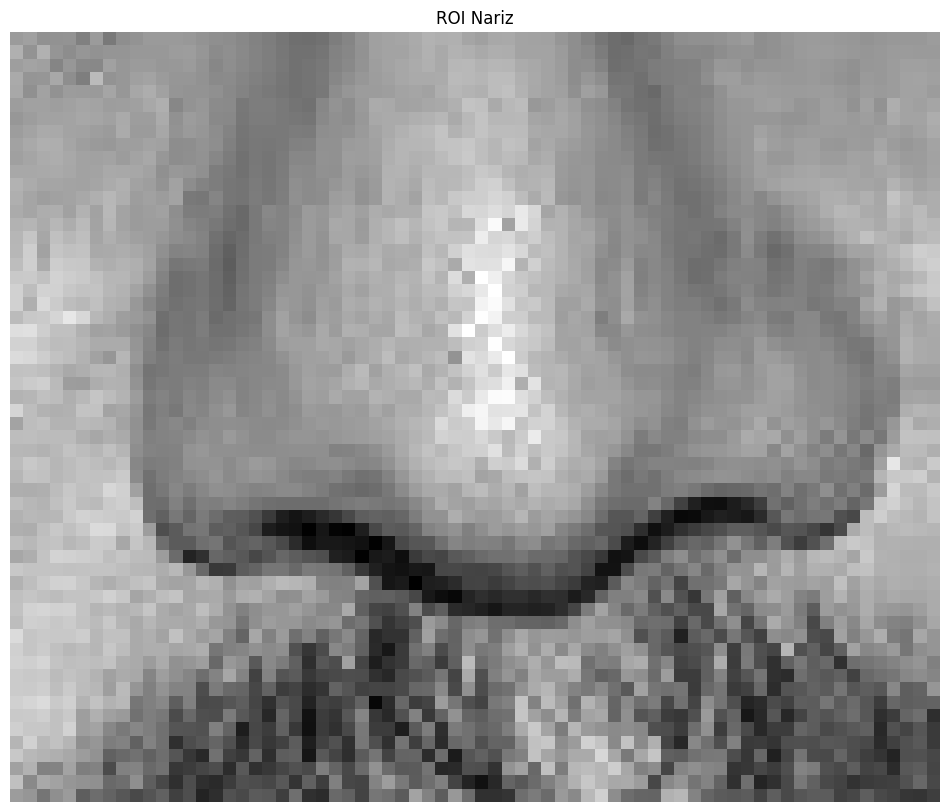

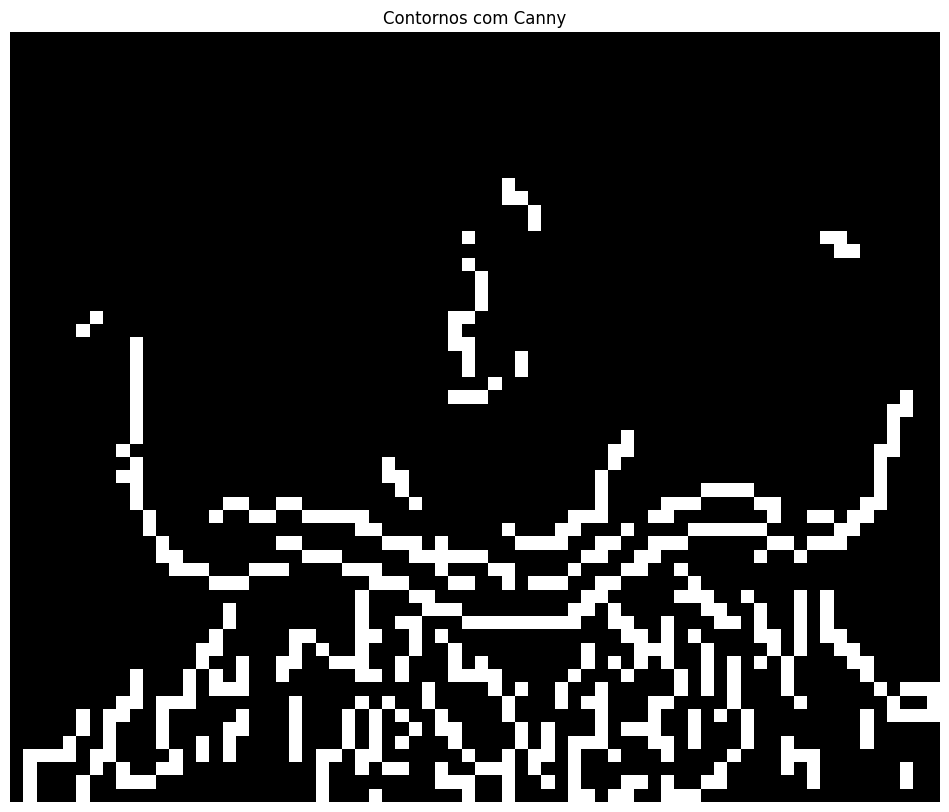

Dicionário de labels: {0: [0, 1, 2, 3, 4], 1: [5], 2: [6, 7, 8, 9], 3: [10, 11, 12, 13, 15, 16, 18, 20, 21, 23, 26], 4: [14, 17], 5: [19, 22, 25, 28, 30, 35, 38, 40, 43, 48, 52, 53, 58, 66, 80, 99, 114, 135, 136, 152, 153, 154, 155, 156, 157, 168, 169, 170], 6: [24, 27], 7: [29, 31, 32, 33], 8: [34, 36, 37, 39, 42, 46, 47, 51, 57, 61, 62, 63, 64, 65, 73, 74, 75, 76, 77, 78, 79, 92, 93, 94, 95, 96, 97, 98, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 127, 128, 129, 130, 131, 132, 133, 134, 137, 138, 139, 148, 149, 150, 151, 158, 159, 160, 165, 166, 171, 172, 173, 180, 181, 183, 184, 185, 186, 187, 195, 196, 197, 198, 199, 200, 201, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 229, 230, 231, 232, 233, 235, 236, 237, 246, 247, 248, 249, 252, 253, 254, 262, 263, 264, 265, 266, 267, 271, 272, 273, 284, 285, 286, 287, 293, 294, 309, 330, 331, 348, 371, 372, 373, 392, 393, 418], 9: [41, 44, 45, 50, 56, 60, 72, 89, 90, 91, 102, 103, 104, 121, 122, 123, 124], 

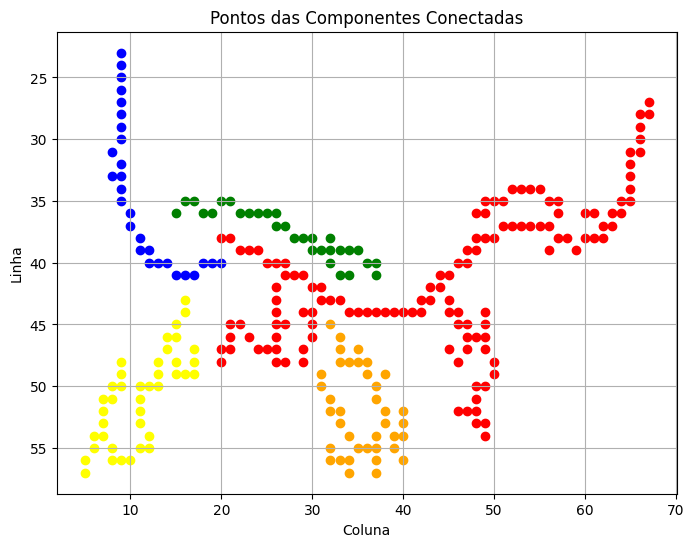

In [6]:

if __name__ == "__main__": 
    all_mAdjNose, mainCoord, image_path = main()
    dicMainComponents, connectedComponentLabels= main_connected_components(all_mAdjNose)
    highlight_components(mainCoord, dicMainComponents)


In [28]:
from scipy.sparse.csgraph import minimum_spanning_tree

class PrincipaisConexos():
    def __init__(self, idx, nodes, min_tree = None, raiz = None, altura = None, caminho_altura_maxima = None, tamanho_caminho_maximo = None, caminho_maximo = None):
        self.idx = idx
        self.nodes = nodes
        self.min_tree = min_tree
        self.raiz = raiz
        self.altura = altura
        self.caminho_altura_maxima = caminho_altura_maxima
        self.tamanho_caminho_maximo = tamanho_caminho_maximo
        self.caminho_maximo = caminho_maximo
mainConnected = []
for key, values in dicMainComponents.items():
    mainConnected.append(PrincipaisConexos(key, values))


for i in range(len(mainConnected)):
    componente = mainConnected[i]
    submatriz_adj = all_mAdjNose[0][np.ix_(mainConnected[i].nodes, mainConnected[i].nodes)]
    min_tree = minimum_spanning_tree(submatriz_adj).toarray().astype(int)
    min_tree += min_tree.T
    mainConnected[i].min_tree = min_tree

class No():
    def __init__(self, idx, filhos=None):
        # Inicializa o nó com o índice 'idx' e uma lista de filhos. Se 'filhos' não for passado,
        # uma nova lista vazia é criada para evitar que uma mesma lista seja compartilhada entre instâncias.
        self.idx = idx
        self.filhos = filhos if filhos is not None else []
        
def constroi_arvore(arvore): # Alterando o argumento para 'arvore' (geral) ao invés de usar 'arvore_3' (específico já criado)
    abertos = []  
    n_nos = len(arvore) 
    if n_nos > 0: 
        raiz = No(0) 
        abertos.append(raiz) 

    proximo_no = 0 
    while proximo_no < len(abertos): 
        no = abertos[proximo_no] 
        proximo_no += 1
        for j in range(n_nos): 
            if arvore[no.idx, j] == 1:
                ja_visitou = False 
                for i in range(proximo_no):
                    if abertos[i].idx == j:
                        ja_visitou = True 
                        break
                if not ja_visitou:
                    filho = No(j) 
                    abertos.append(filho)
                    no.filhos.append(filho)
    return raiz
for i in range(len(mainConnected)):
    mainConnected[i].raiz = constroi_arvore(mainConnected[i].min_tree)
def podando_arvore(raiz):
    if len(raiz.filhos) == 0: # Condição base (nó folha)
        return 1, [raiz.idx], 1, [raiz.idx] # Se o nó não tiver filhos, sua altura é 0 e seu caminho é ele mesmo
    else: # Caso recursivo (nó com filhos)
        for filho in raiz.filhos: 
            # print('filho:', filho.idx)
            filho.altura, filho.caminho_altura_maxima, filho.tamanho_caminho_maximo, filho.caminho_maximo = podando_arvore(filho) # Para cada filho do nó atual, a função é chamada recursivamente, retornando a altura e o caminho para cada um dos filhos.

        if len(raiz.filhos) == 1:
            if raiz.filhos[0].altura + 1 > raiz.filhos[0].tamanho_caminho_maximo:
                tamanho_caminho_maximo = raiz.filhos[0].altura + 1
                caminho_maximo = [raiz.idx] + raiz.filhos[0].caminho_altura_maxima
            else:
                tamanho_caminho_maximo = raiz.filhos[0].tamanho_caminho_maximo
                caminho_maximo = raiz.filhos[0].caminho_maximo
        else:
            raiz.filhos.sort(key=lambda x: x.altura, reverse=True)
            tamanho_caminho_maximo = raiz.filhos[0].altura + raiz.filhos[1].altura + 1
            uma_parte_do_caminho = raiz.filhos[0].caminho_altura_maxima.copy()
            uma_parte_do_caminho.reverse()
            caminho_maximo = uma_parte_do_caminho + [raiz.idx] + raiz.filhos[1].caminho_altura_maxima
            for filho in raiz.filhos: 
                if filho.tamanho_caminho_maximo > tamanho_caminho_maximo:
                    tamanho_caminho_maximo = filho.tamanho_caminho_maximo 
                    caminho_maximo = filho.caminho_maximo

        no_altura_maxima = raiz.filhos[0] # max(raiz.filhos, key=lambda x: x.altura) # Entre todos os filhos, o código encontra aquele que tem a maior altura (o caminho mais longo até uma folha).

        return no_altura_maxima.altura + 1, [raiz.idx] + no_altura_maxima.caminho_altura_maxima, tamanho_caminho_maximo, caminho_maximo # A altura retornada é incrementada em 1, pois estamos subindo um nível na árvore, e o caminho máximo é atualizado para incluir o nó atual (raiz.idx) na frente da lista.


def plot_caminhos(mainCoord, maiores_caminhos, idx_desejado):
    plt.figure(figsize=(13, 13))

    # Plotar todos os nós como pontos
    coords = np.array(mainCoord)
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'purple', 'pink', 'brown', 'gray']
    cor=0
    anotacao = {}
    # plt.scatter(coords[:, 1], coords[:, 0], s=50, color='black', label='Nó')

    if set(idx_desejado).issubset(set([connected.idx for connected in mainConnected])):
        i = 0

        for connected in mainConnected:
            if connected.idx in idx_desejado:
            # Verificar se o idx_desejado está no dicionário
            # if idx_desejado in maiores_caminhos:
                caminho = maiores_caminhos[connected.idx]
                # Iterar por pares de nós no caminho
                anotacao_coordendas = []
                label = []
                for i in range(len(caminho) - 1):
                    node_idx = connected.nodes[caminho[i]]
                    coord_inicial = coords[node_idx]    # Coordenada do nó inicial
                    next_node_idx = connected.nodes[caminho[i+1]]
                    coord_final = coords[next_node_idx]  # Coordenada do nó seguinte
                    
                    # Plotar a linha conectando os nós do componente desejado
                    plt.plot([coord_inicial[1], coord_final[1]], [coord_inicial[0], coord_final[0]], 'o-', label=f'Componente {connected.idx}' if i == 0 else "", linewidth=2, color=colors[cor])
                    
                    # Anotar o número do nó no gráfico
                    plt.annotate(f'{i}', (coord_inicial[1], coord_inicial[0]), textcoords="offset points", xytext=(0,5), ha='center', color='black')
                    anotacao_coordendas.append((coord_inicial[1], coord_inicial[0]))
                    label.append(i)

                anotacao[connected.idx] = anotacao_coordendas
                cor +=1
                
                # Anotar o último nó do caminho
                last_node_idx = connected.nodes[caminho[-1]]
                plt.annotate(f'{len(caminho) - 1}', (coords[last_node_idx][1], coords[last_node_idx][0]), textcoords="offset points", xytext=(0,5), ha='center', color='black')
                anotacao[connected.idx].append((coords[last_node_idx][1], coords[last_node_idx][0]))
    else:
        print(f"Componentes não encontrados: {set(idx_desejado) - set([connected.idx for connected in mainConnected])}")


    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.title(f'Maiores Caminhos - Componente {idx_desejado}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.gca().invert_yaxis()  # Inverter o eixo y para corresponder à orientação das imagens OpenCV
    plt.show()

    return anotacao

In [29]:
maiores_caminhos = {}

for i in range(len(mainConnected)):
     print(podando_arvore(mainConnected[i].raiz)[0])
     print(podando_arvore(mainConnected[i].raiz)[1])
     print(podando_arvore(mainConnected[i].raiz)[2])
     print(podando_arvore(mainConnected[i].raiz)[3])
     maiores_caminhos[mainConnected[i].idx] = podando_arvore(mainConnected[i].raiz)[3]
     print('-----------------')

25
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 25, 26, 27, 22, 23, 24]
25
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 25, 26, 27, 22, 23, 24]
-----------------
61
[0, 1, 3, 4, 5, 7, 8, 13, 19, 26, 34, 44, 43, 52, 42, 41, 33, 32, 31, 30, 29, 28, 40, 39, 38, 49, 56, 62, 61, 66, 72, 85, 84, 83, 82, 81, 80, 79, 78, 71, 70, 65, 64, 60, 59, 55, 54, 58, 63, 68, 75, 92, 100, 108, 107, 99, 91, 90, 98, 105, 114]
62
[114, 105, 98, 90, 91, 99, 107, 108, 100, 92, 75, 68, 63, 58, 54, 55, 59, 60, 64, 65, 70, 71, 78, 79, 80, 81, 82, 83, 84, 85, 72, 66, 61, 62, 56, 49, 38, 39, 40, 28, 29, 30, 31, 32, 33, 41, 42, 52, 43, 44, 34, 26, 19, 13, 8, 7, 5, 4, 3, 1, 0, 2]
-----------------
22
[0, 1, 5, 6, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 19, 17, 21, 22, 23, 25, 26]
23
[26, 25, 23, 22, 21, 17, 19, 16, 15, 14, 13, 11, 10, 9, 8, 7, 3, 2, 6, 5, 1, 0, 4]
-----------------
24
[0, 1, 2, 3, 5, 8, 12, 19, 18, 23, 25, 27, 30, 33, 38, 37, 32, 29, 26, 24, 21, 16, 11, 7]
2

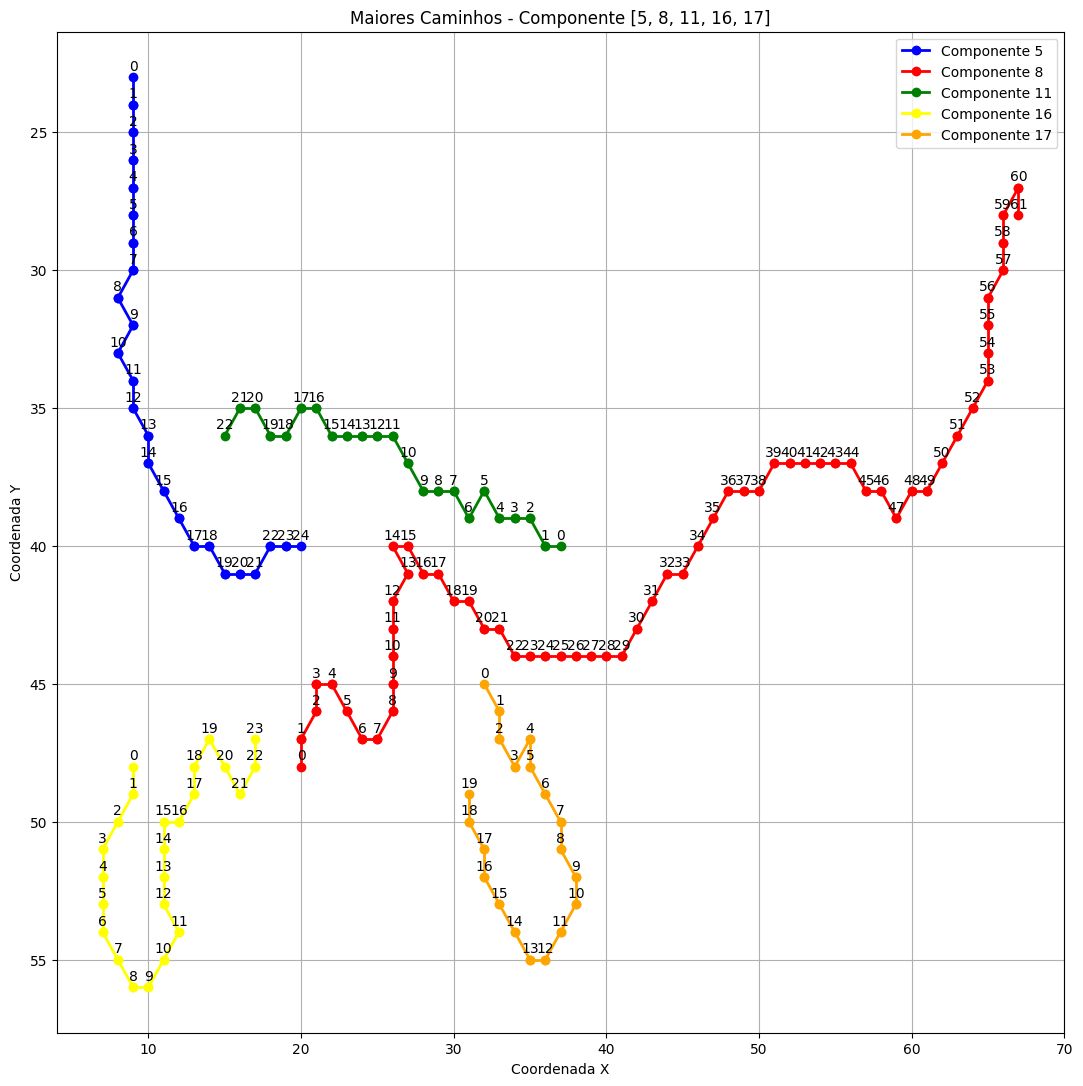

In [30]:
anotacao = plot_caminhos(mainCoord, maiores_caminhos, idx_desejado=[connected.idx for connected in mainConnected])

In [31]:
novo_maiores_caminhos = {}
for key, value in maiores_caminhos.items():
    print('Componente:', key)
    print('Caminho:', value)
    print('Tamanho do caminho:', len(value))

    # Garante que o primeiro e o último elementos estejam na amostra
    primeiro_elemento = value[0]
    ultimo_elemento = value[-1]

    # Exclui o segundo e o penúltimo elementos da seleção, além do primeiro e do último
    intermediarios = value[2:-2]  # Exclui o primeiro, segundo, penúltimo e último

    # Calcula quantos elementos aleatórios ainda precisam ser adicionados
    tamanho_amostra = int(len(value) * 0.4) - 2 # -2 para o primeiro e o último já selecionados

    amostra_intermediarios = []
    indices_usados = set()

    while len(amostra_intermediarios) < tamanho_amostra:
        indice = random.choice(range(len(intermediarios)))
        # Verifica se o índice ou o consecutivo estão usados
        if indice not in indices_usados and (indice - 1) not in indices_usados and (indice + 1) not in indices_usados:
            amostra_intermediarios.append(intermediarios[indice])
            indices_usados.add(indice)

    # Ordena para manter a ordem original da lista
    amostra_intermediarios.sort(key=value.index)
    
    # Junta tudo mantendo a ordem original: primeiro, intermediários em ordem, último
    amostra = [primeiro_elemento] + amostra_intermediarios + [ultimo_elemento]
    novo_maiores_caminhos[key] = amostra
    print('Amostra:', amostra)
    print('-----------------')

Componente: 5
Caminho: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 20, 21, 25, 26, 27, 22, 23, 24]
Tamanho do caminho: 25
Amostra: [0, 3, 5, 9, 13, 15, 18, 25, 22, 24]
-----------------
Componente: 8
Caminho: [114, 105, 98, 90, 91, 99, 107, 108, 100, 92, 75, 68, 63, 58, 54, 55, 59, 60, 64, 65, 70, 71, 78, 79, 80, 81, 82, 83, 84, 85, 72, 66, 61, 62, 56, 49, 38, 39, 40, 28, 29, 30, 31, 32, 33, 41, 42, 52, 43, 44, 34, 26, 19, 13, 8, 7, 5, 4, 3, 1, 0, 2]
Tamanho do caminho: 62
Amostra: [114, 98, 91, 107, 75, 54, 70, 79, 82, 84, 72, 61, 56, 38, 40, 31, 33, 42, 44, 19, 8, 5, 3, 2]
-----------------
Componente: 11
Caminho: [26, 25, 23, 22, 21, 17, 19, 16, 15, 14, 13, 11, 10, 9, 8, 7, 3, 2, 6, 5, 1, 0, 4]
Tamanho do caminho: 23
Amostra: [26, 22, 17, 16, 11, 9, 7, 2, 4]
-----------------
Componente: 16
Caminho: [7, 11, 16, 21, 24, 26, 29, 32, 37, 38, 33, 30, 27, 25, 23, 18, 19, 12, 8, 5, 9, 14, 10, 6]
Tamanho do caminho: 24
Amostra: [7, 16, 24, 37, 33, 19, 5, 14, 6]
-------------

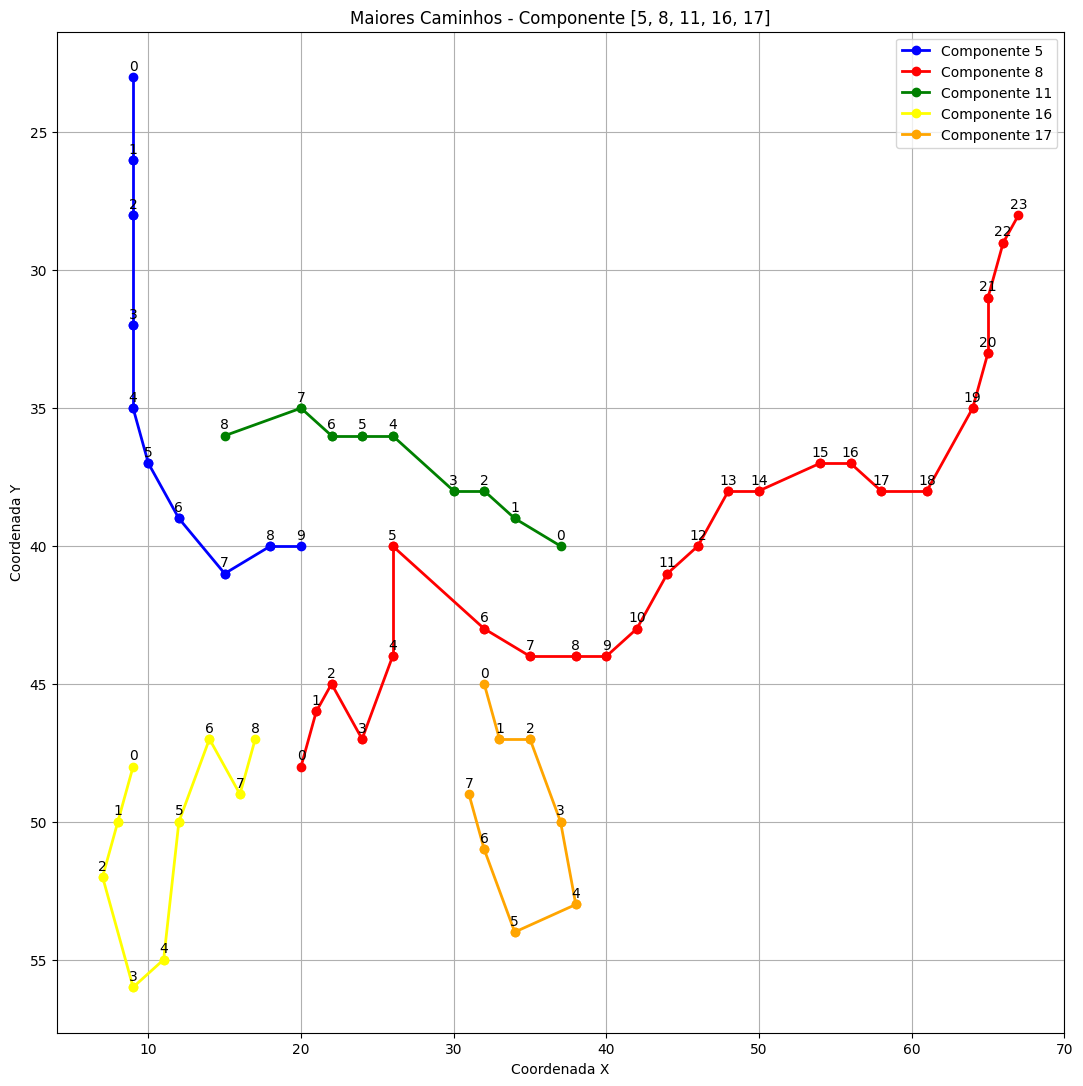

In [32]:
anotacao_novo_maiores_caminhos = plot_caminhos(mainCoord, novo_maiores_caminhos, idx_desejado=[connected.idx for connected in mainConnected])

In [33]:
anotacao_novo_maiores_caminhos

{5: [(9, 23),
  (9, 26),
  (9, 28),
  (9, 32),
  (9, 35),
  (10, 37),
  (12, 39),
  (15, 41),
  (18, 40),
  (20, 40)],
 8: [(20, 48),
  (21, 46),
  (22, 45),
  (24, 47),
  (26, 44),
  (26, 40),
  (32, 43),
  (35, 44),
  (38, 44),
  (40, 44),
  (42, 43),
  (44, 41),
  (46, 40),
  (48, 38),
  (50, 38),
  (54, 37),
  (56, 37),
  (58, 38),
  (61, 38),
  (64, 35),
  (65, 33),
  (65, 31),
  (66, 29),
  (67, 28)],
 11: [(37, 40),
  (34, 39),
  (32, 38),
  (30, 38),
  (26, 36),
  (24, 36),
  (22, 36),
  (20, 35),
  (15, 36)],
 16: [(9, 48),
  (8, 50),
  (7, 52),
  (9, 56),
  (11, 55),
  (12, 50),
  (14, 47),
  (16, 49),
  (17, 47)],
 17: [(32, 45),
  (33, 47),
  (35, 47),
  (37, 50),
  (38, 53),
  (34, 54),
  (32, 51),
  (31, 49)]}

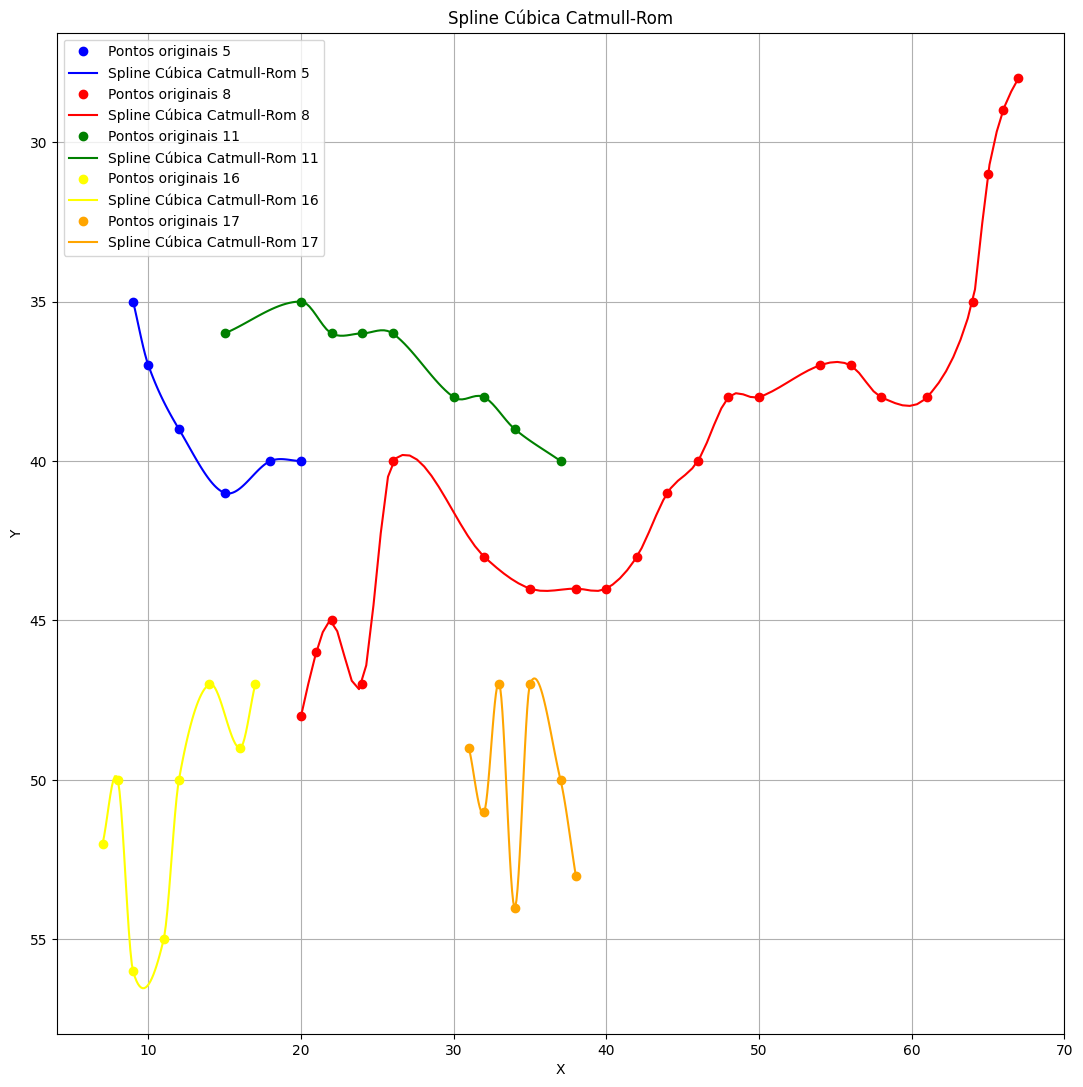

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline

# Definindo as cores para cada spline
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black']

# Criando uma nova figura
plt.figure(figsize=(13, 13))

for idx, (key, value) in enumerate(anotacao_novo_maiores_caminhos.items()):
    # Dados
    data = anotacao_novo_maiores_caminhos[key]

    # Extraindo as coordenadas x e y
    coordenadas = np.array(data)
    x = coordenadas[:, 0]
    y = coordenadas[:, 1]

    # Remover duplicatas e manter a ordem
    unique_coords = {k: v for k, v in zip(x, y)}
    unique_x = np.array(list(unique_coords.keys()))
    unique_y = np.array(list(unique_coords.values()))

    # Reorganizando os pontos para um x crescente
    indices = np.argsort(unique_x)
    x_sorted = unique_x[indices]
    y_sorted = unique_y[indices]

    # Criando a spline cúbica Catmull-Rom
    n = len(x_sorted)

    # Inicializando a lista de tangentes
    tangents = np.zeros(n)

    # Calculando as tangentes
    for i in range(1, n - 1):
        tangents[i] = (y_sorted[i + 1] - y_sorted[i - 1]) / (x_sorted[i + 1] - x_sorted[i - 1])

    # Definindo as tangentes para o primeiro e o último ponto
    tangents[0] = (y_sorted[1] - y_sorted[0]) / (x_sorted[1] - x_sorted[0])
    tangents[-1] = (y_sorted[-1] - y_sorted[-2]) / (x_sorted[-1] - x_sorted[-2])

    # Usando a spline de Hermite
    cs = CubicHermiteSpline(x_sorted, y_sorted, tangents)

    # Criando pontos para a linha da spline
    x_new = np.linspace(x_sorted.min(), x_sorted.max(), 100)
    y_new = cs(x_new)

    # Plotando os pontos e a spline com a cor correspondente
    plt.plot(x_sorted, y_sorted, 'o', label=f'Pontos originais {key}', color=colors[idx % len(colors)])
    plt.plot(x_new, y_new, '-', label=f'Spline Cúbica Catmull-Rom {key}', color=colors[idx % len(colors)])

# Configurações do gráfico
plt.title('Spline Cúbica Catmull-Rom')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.gca().invert_yaxis()  # Inverter o eixo y para corresponder à orientação das imagens OpenCV
plt.show()


In [45]:
anotacao_novo_maiores_caminhos

{5: [(9, 23),
  (9, 26),
  (9, 28),
  (9, 32),
  (9, 35),
  (10, 37),
  (12, 39),
  (15, 41),
  (18, 40),
  (20, 40)],
 8: [(20, 48),
  (21, 46),
  (22, 45),
  (24, 47),
  (26, 44),
  (26, 40),
  (32, 43),
  (35, 44),
  (38, 44),
  (40, 44),
  (42, 43),
  (44, 41),
  (46, 40),
  (48, 38),
  (50, 38),
  (54, 37),
  (56, 37),
  (58, 38),
  (61, 38),
  (64, 35),
  (65, 33),
  (65, 31),
  (66, 29),
  (67, 28)],
 11: [(37, 40),
  (34, 39),
  (32, 38),
  (30, 38),
  (26, 36),
  (24, 36),
  (22, 36),
  (20, 35),
  (15, 36)],
 16: [(9, 48),
  (8, 50),
  (7, 52),
  (9, 56),
  (11, 55),
  (12, 50),
  (14, 47),
  (16, 49),
  (17, 47)],
 17: [(32, 45),
  (33, 47),
  (35, 47),
  (37, 50),
  (38, 53),
  (34, 54),
  (32, 51),
  (31, 49)]}

In [39]:
control_x

[9, 9, 9, 9, 9, 10, 12, 15, 18, 20]

GIF salvo como 'interpolacao_catmull_rom.gif'


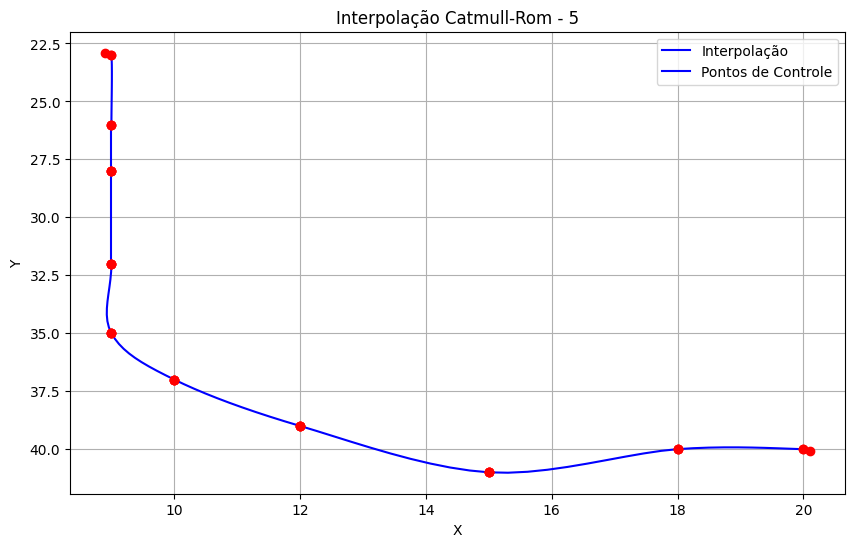

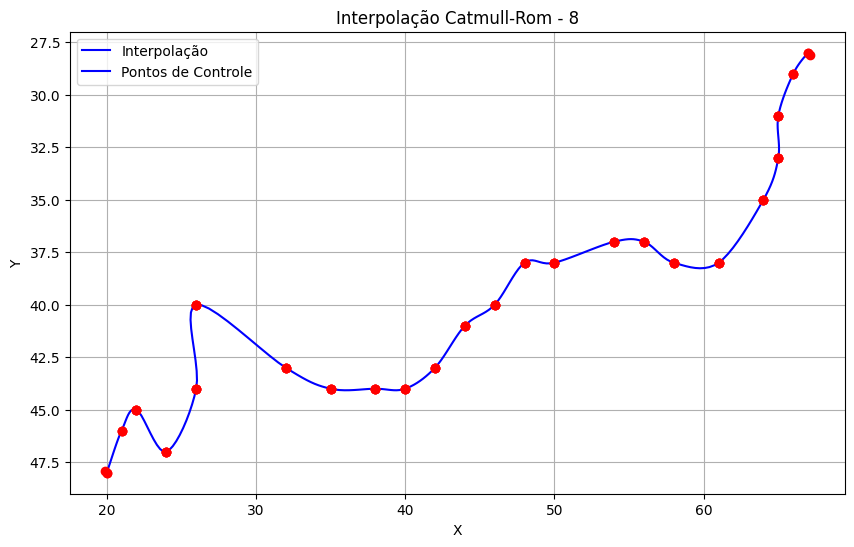

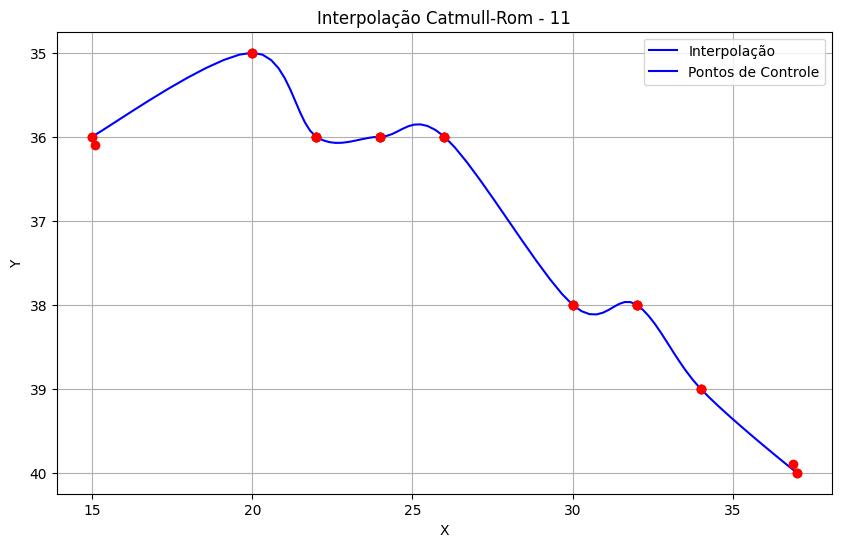

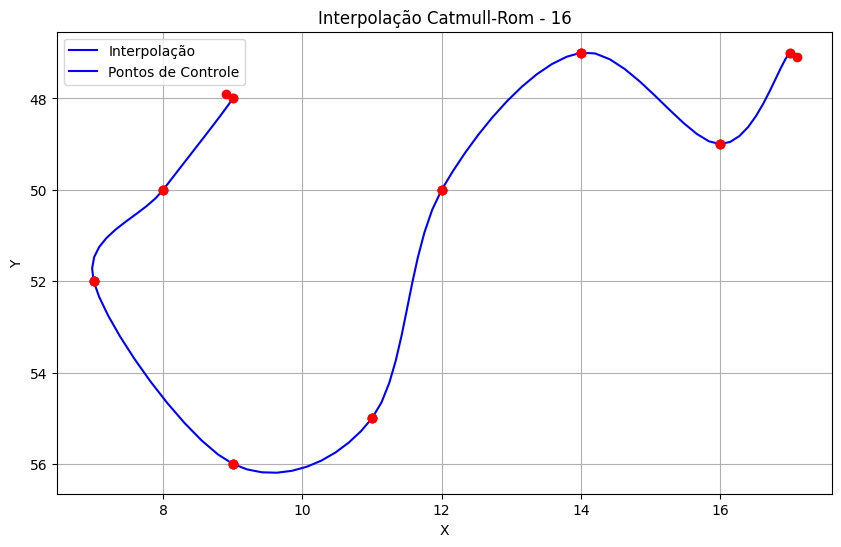

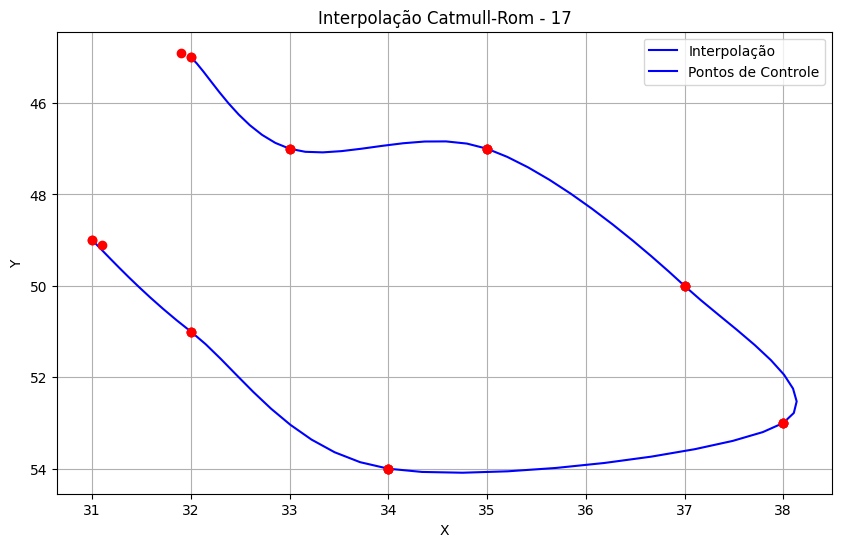

In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Supondo que a função catmull_rom_t já esteja definida
# ...

# Lista para armazenar todos os frames
all_frames = []

# Loop sobre cada chave em anotacao_novo_maiores_caminhos
for key, value in anotacao_novo_maiores_caminhos.items():
    # Extraindo as coordenadas x e y
    coordenadas = anotacao_novo_maiores_caminhos[key]
    control_x = [coord[0] for coord in coordenadas]
    control_y = [coord[1] for coord in coordenadas]

    # Adicionando pontos fantasmas
    control_x.insert(0, control_x[0] - 0.1)
    control_x.append(control_x[-1] + 0.1)
    control_y.insert(0, control_y[0] - 0.1)
    control_y.append(control_y[-1] + 0.1)

    T = 1
    t = np.arange(0, 1.1, 0.1)
    N = len(control_x)

    interpolated_points = np.zeros((len(t), 2))
    X = np.zeros((len(t), N - 3))
    Y = np.zeros((len(t), N - 3))

    vx = np.zeros((N - 3, 4))
    vy = np.zeros((N - 3, 4))
    for i in range(N - 3):
        vx[i, :] = control_x[i:i + 4]
        vy[i, :] = control_y[i:i + 4]

    S = vx.shape

    for i in range(S[0]):
        vx1 = vx[i, :]
        vy1 = vy[i, :]
        q_aux = catmull_rom_t(vx1, vy1, T)
        for j in range(len(t)):
            interpolated_points[j] = q_aux(t[j])
        X[:, i] = interpolated_points[:, 0]
        Y[:, i] = interpolated_points[:, 1]

    # Criação da animação com matplotlib e armazenamento de frames com Pillow
    plt.figure(figsize=(10, 6))

    for i in range(N - 3):
        plt.clf()  # Limpa a figura antes de plotar o próximo frame

        # Plota os dados interpolados e pontos de controle até o índice i
        plt.plot(X[:, :i + 1], Y[:, :i + 1], 'b-')  # Interpolação
        plt.plot(vx[:i + 1], vy[:i + 1], 'ro')  # Pontos de controle

        plt.gca().invert_yaxis()
        plt.title(f'Interpolação Catmull-Rom - {key}')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend(['Interpolação', 'Pontos de Controle'])
        plt.grid(True)

        # Salva o frame atual como uma imagem
        plt.draw()
        os.makedirs("frames", exist_ok=True)  # Cria o diretório 'frames' se ele não existir
        frame_path = f"./frames/frame_{key}_{i}.png"
        plt.savefig(frame_path)  # Salva o frame atual
        all_frames.append(Image.open(frame_path))  # Adiciona o frame como imagem na lista

# Cria o GIF a partir dos frames salvos
all_frames[0].save("interpolacao_catmull_rom.gif", save_all=True, append_images=all_frames[1:], duration=300, loop=0)

print("GIF salvo como 'interpolacao_catmull_rom.gif'")
plt.show()
